In [ ]:
import os

import numpy as np
from typing import List, Tuple, Any

import seaborn as sns
import matplotlib.pyplot as plt
import torch

import project_path

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from attwizard.decoder import get_attention_tensor
from attwizard.decoder import merge_attention_prompt_and_new_tokens
from attwizard.decoder import get_attention_matrix
from attwizard.decoder import condense_attention
from attwizard.decoder import heatmap_visualize

import torch

In [ ]:
MODEL_FOLDER = "../huggingface_models/gpt-neo"
FOLDER_WITH_SAMPLES = "code_snippet_samples"

In [ ]:
from transformers import AutoTokenizer, GPTNeoForCausalLM

if os.path.exists(os.path.join(MODEL_FOLDER, "pytorch_model.bin")):
    print("Model loaded locally...")
    
    tokenizer = AutoTokenizer.from_pretrained(MODEL_FOLDER)
    model = GPTNeoForCausalLM.from_pretrained(MODEL_FOLDER)
else:
    print("Model downloaded...")
    
    tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")
    model = GPTNeoForCausalLM.from_pretrained("EleutherAI/gpt-neo-125M")
    
    tokenizer.save_pretrained("../huggingface_models/gpt-neo")
    model.save_pretrained("../huggingface_models/gpt-neo")
print(model)

Model loaded locally...
GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0, inplace=False)
    (h): ModuleList(
      (0): GPTNeoBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0, inplace=False)
            (resid_dropout): Dropout(p=0, inplace=False)
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=False)
            (q_proj): Linear(in_features=768, out_features=768, bias=False)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (c_proj): Li

In [ ]:
prompt = open(os.path.join(FOLDER_WITH_SAMPLES, "short_recall_test.py"), 'r').read()
print(prompt)

alice = 3
b = 5
column = alice
print(column)


In [ ]:
input_ids = tokenizer(prompt, return_tensors="pt").input_ids
torch.manual_seed(42)

model_output = model.generate(
    input_ids,
    do_sample=True,
    #temperature=0.0000001,
    temperature=0.8,
    output_attentions=True,
    max_length=50, 
    return_dict_in_generate=True
)
att_tensor = get_attention_tensor(
    model_output=model_output
)
condensed_att_tensor = \
    merge_attention_prompt_and_new_tokens(att_tensor)
condensed_att_tensor = \
    condense_attention(
        condensed_att_tensor, 
        reduce_direction="both",
        reduce_function=torch.amax)
att_matrix = get_attention_matrix(
    attention_tensor=condensed_att_tensor)
generated_text = tokenizer.decode(model_output["sequences"][0])
print(generated_text)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


alice = 3
b = 5
column = alice
print(column)

For a 3-column table, you can pass the column like this:
print(column['Alice'][0]
print(column


In [ ]:
from ipywidgets import interact
from attwizard.decoder import get_attention_representation
from attwizard.aligner import map_to_char_level
from attwizard.aligner import tokenize_char_level

from codeattention.source_code import SourceCode

def show_att_map_position(token_pos):
    """Show the attention map of a specific token position."""
    global model_output
    global generated_text
    global tokens_gpt_generated
    print(f"You see the weights of attention to represent the token: {tokens_gpt_generated[token_pos]}")
    print(f"This token representation is used to predict all the tokens after this.")
    # extract the weights for that token representation
    att_weights = get_attention_representation(att_matrix, token_pos=token_pos)
    att_weights = list(att_weights.numpy())
    # append 1 because the last token is unattended, it is simply generated 
    # attending the previous ones.
    att_weights.append(0)
    print(len(att_weights))
    # convert the attntion to char level (easier to compare and display)
    att_weights_gpt_neo_char_level = map_to_char_level(
        tokens=tokens_gpt_generated,
        att_weights=att_weights,
        raw_text=generated_text,
        #distribution_fn="equal_share",
        distribution_fn="replication",
        special_char_mapping={
            "Ġ": ' ',
            "Ċ": '\n',
        }
    )
    char_tokens = tokenize_char_level(generated_text)
    # display
    python_sc = SourceCode(char_tokens)
    fig, ax = python_sc.show_with_weights(
        weights=att_weights_gpt_neo_char_level,
        show_line_numbers=True
    )

tokens_gpt_generated = tokenizer.convert_ids_to_tokens(model_output["sequences"][0])
gpt_tokens_labels = [
    (t[1], t[0]) for t in list(enumerate(tokens_gpt_generated))
]    

interact(show_att_map_position, token_pos=gpt_tokens_labels);

interactive(children=(Dropdown(description='token_pos', options=(('al', 0), ('ice', 1), ('Ġ=', 2), ('Ġ3', 3), …

This view aggregates all the layers and heads with a max function


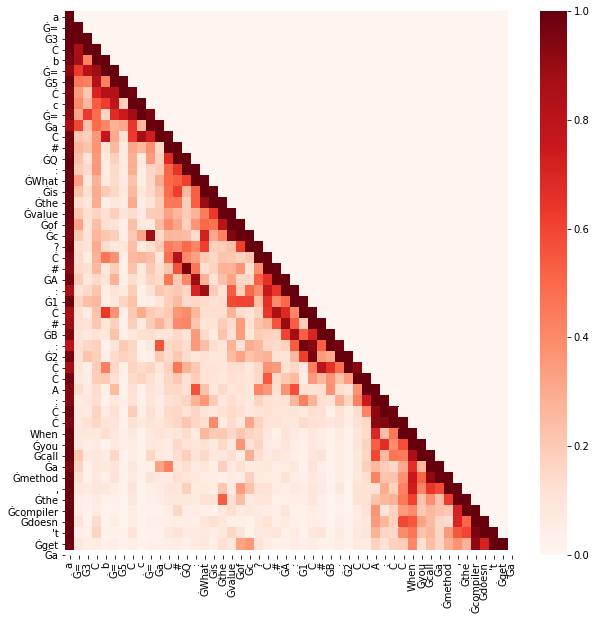

In [9]:
heatmap_visualize(
    attention_matrix=att_matrix,
    token_names=tokenizer.convert_ids_to_tokens(model_output["sequences"][0])
)
print("This view aggregates all the layers and heads with a max function")

<AxesSubplot:>

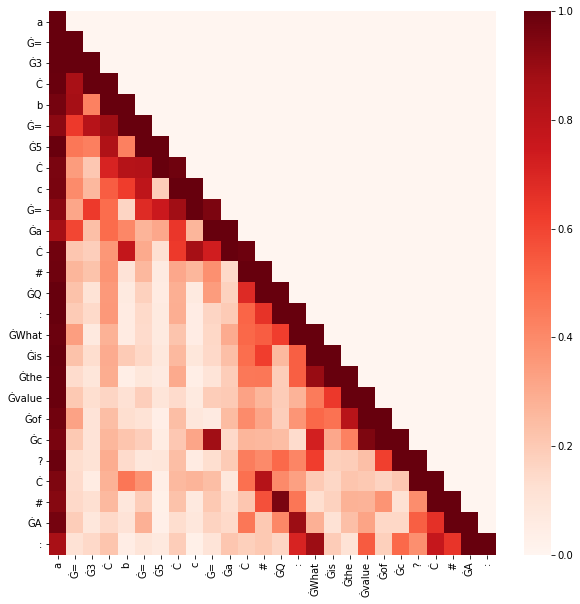

In [10]:
TOKEN_POSITION = 26
reduced_att_matrix = att_matrix[:TOKEN_POSITION, : TOKEN_POSITION]
heatmap_visualize(
    attention_matrix=reduced_att_matrix,
    token_names=tokenizer.convert_ids_to_tokens(model_output["sequences"][0][:TOKEN_POSITION])
)

<AxesSubplot:>

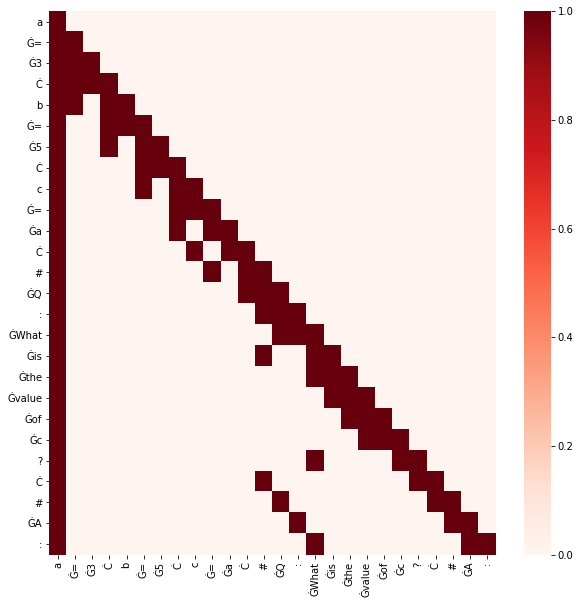

In [83]:
# get the top k in each row of reduced_att_matrix
top_k = 4
top_k_att_matrix = np.zeros_like(reduced_att_matrix)
for i in range(reduced_att_matrix.shape[0]):
    to_pick = min(reduced_att_matrix[i, :].count_nonzero(), top_k)
    indices_to_change = np.argsort(reduced_att_matrix[i, :])[-to_pick:]
    for idx in indices_to_change:
        top_k_att_matrix[i, idx] = 1
heatmap_visualize(
    attention_matrix=top_k_att_matrix,
    token_names=tokenizer.convert_ids_to_tokens(model_output["sequences"][0][:TOKEN_POSITION])
)

In [84]:
import networkx as nx
import numpy as np

G = nx.from_numpy_matrix(top_k_att_matrix)

[0.13833156785232065,
 0.03154756027058213,
 0.026297828527405708,
 0.041622015235795624,
 0.030879597434348437]

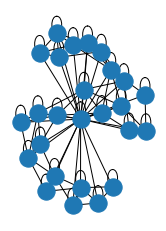

In [85]:
subax1 = plt.subplot(121)
nx.draw(G) 
pr = nx.pagerank(G, alpha=0.85)
page_rank_att_weights = list(pr.values())
page_rank_att_weights[:5]

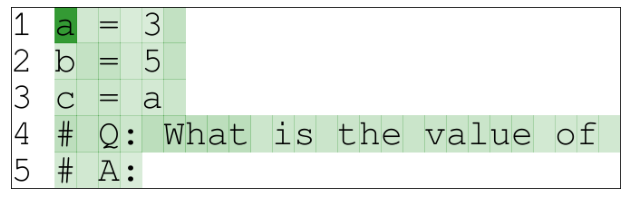

In [86]:

tokens_prompt = tokenizer.convert_ids_to_tokens(input_ids[0])

# convert the attntion to char level (easier to compare and display)
att_weights_gpt_neo_char_level = map_to_char_level(
    tokens=tokens_prompt,
    att_weights=page_rank_att_weights,
    raw_text=prompt,
    #distribution_fn="equal_share",
    distribution_fn="replication",
    special_char_mapping={
        "Ġ": ' ',
        "Ċ": '\n',
    }
)
char_tokens = tokenize_char_level(prompt)
# display
python_sc = SourceCode(char_tokens)
fig, ax = python_sc.show_with_weights(
    weights=att_weights_gpt_neo_char_level,
    show_line_numbers=True
)
